In [1]:
import warnings
warnings.filterwarnings('ignore')
import flowermd
import hoomd
from flowermd.library import PolyEthylene, OPLS_AA
from flowermd import Pack
from flowermd.modules.welding import SlabSimulation, Interface, WeldSimulation
from cmeutils.visualize import FresnelGSD
import gsd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import unyt as u
molecule = PolyEthylene(num_mols=30, lengths=12)
cpu = hoomd.device.CPU() # So I don't get a CUDA error

# Create a slab
system = Pack(
    molecules=molecule,
    density=1.1 * u.g/u.cm**3,
)
system.apply_forcefield(r_cut=2.5, force_field=OPLS_AA(), auto_scale=True,remove_charges=True, remove_hydrogens=True)
sim = SlabSimulation.from_system(
    system=system,
    interface_axis=(1,0,0),
    gsd_file_name="slab_x_interface.gsd", device = cpu
)
sim.forces
for wall in sim.forces[-1].walls:
    print(wall)
print()
print("Simulation volume:", sim.box_lengths_reduced)
target_box = flowermd.utils.get_target_box_mass_density(density=1.2*u.g/u.cm**3, mass=sim.mass.to("g"))

sim.run_update_volume(final_box_lengths=target_box, n_steps=5e4, kT=5.0, period=100, tau_kt=0.001)
sim.run_NVT(kT=5.0, n_steps=4e4, tau_kt=0.001)
sim.remove_walls(wall_axis=(1,0,0))
sim.pickle_forcefield()
sim.flush_writers()
sim_viewer = FresnelGSD(gsd_file="slab_x_interface.gsd", view_axis=(0, 1, 0), frame=-1)
sim_viewer.view()

# Create interface from the slab
interface = Interface(gsd_files=["slab_x_interface.gsd"], interface_axis=(1, 0, 0), gap=0.05)
print(type(interface.hoomd_snapshot))
print("Slab number of particles:", system.n_particles)
print("Interface number of particles:", interface.hoomd_snapshot.particles.N)
print()
print("Slab box lengths:", sim.box_lengths_reduced)
print("Interface box lengths:", interface.hoomd_snapshot.configuration.box[:3])

/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/mdtraj/formats/__init__.py:13: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from mdtraj.formats.trr import TRRTrajectoryFile


No charged group detected, skipping electrostatics.
Initializing simulation state from a gsd.hoomd.Frame.
Plane(origin=_HOOMDTuple(17.74683380126953, 0.0, 0.0), normal=_HOOMDTuple(-1.0, 0.0, 0.0), 
Plane(origin=_HOOMDTuple(-17.74683380126953, -0.0, -0.0), normal=_HOOMDTuple(1.0, 0.0, 0.0), 

Simulation volume: [35.4936676 35.4936676 35.4936676]
Step 5500 of 50000; TPS: 4048.57; ETA: 0.2 minutes
Step 11000 of 50000; TPS: 4324.09; ETA: 0.2 minutes
Step 16500 of 50000; TPS: 4428.53; ETA: 0.1 minutes
Step 22000 of 50000; TPS: 4423.68; ETA: 0.1 minutes
Step 27500 of 50000; TPS: 4406.98; ETA: 0.1 minutes
Step 33000 of 50000; TPS: 4319.91; ETA: 0.1 minutes
Step 38500 of 50000; TPS: 4187.67; ETA: 0.0 minutes
Step 44000 of 50000; TPS: 3892.85; ETA: 0.0 minutes
Step 49500 of 50000; TPS: 3296.74; ETA: 0.0 minutes
Step 4999 of 40000; TPS: 973.62; ETA: 0.6 minutes
Step 10499 of 40000; TPS: 974.75; ETA: 0.5 minutes
Step 15999 of 40000; TPS: 976.63; ETA: 0.4 minutes
Step 21499 of 40000; TPS: 980.03; 

In [2]:
# # Create interface from the slab
# interface = Interface(gsd_files=["slab_x_interface.gsd"], interface_axis=(1, 0, 0), gap=0.05)
# print(type(interface.hoomd_snapshot))
# print("Slab number of particles:", system.n_particles)
# print("Interface number of particles:", interface.hoomd_snapshot.particles.N)
# print()
# print("Slab box lengths:", sim.box_lengths_reduced)
# print("Interface box lengths:", interface.hoomd_snapshot.configuration.box[:3])

# # Running a welding simulation
# # Open and load the forcefield picke file
# with open("forcefield.pickle", "rb") as f:
#     hoomd_forces = pickle.load(f)


# weld_sim = WeldSimulation(
#     initial_state=interface.hoomd_snapshot,
#     forcefield=hoomd_forces,
#     interface_axis=(1, 0, 0),
#     gsd_file_name="weld.gsd",
#     log_file_name="weld_log.txt",
#     log_write_freq=500,
#     dt=0.0003, device = cpu
# )
# weld_sim.forces
# for wall in weld_sim.forces[-1].walls:
#     print(wall)
# print()
# print("Simulation volume:", weld_sim.box_lengths_reduced)
# weld_sim.run_NVT(kT=10.0, n_steps=7e4, tau_kt=0.001)
# cooling_ramp = weld_sim.temperature_ramp(n_steps=2e4, kT_start=10.0, kT_final=2.0)
# weld_sim.run_NVT(kT=cooling_ramp, n_steps=2e4, tau_kt=0.001)
# weld_sim.save_restart_gsd("weld_restart.gsd")
# weld_sim.flush_writers()
# sim_viewer = FresnelGSD(gsd_file="weld.gsd", view_axis=(0, 1, 0), frame=0, height=12)
# weld_colors = np.zeros_like(sim_viewer.positions)
# weld_colors[:weld_colors.shape[0]//2 + 1] = np.array([0.5, 0.25, 0.5])
# weld_colors[weld_colors.shape[0]//2 + 1:] = np.array([0.5, 0.1, 0.1])
# sim_viewer.colors = weld_colors
# sim_viewer.view(width=500, height=500)

<class 'gsd.hoomd.Frame'>
Slab number of particles: 720
Interface number of particles: 1440

Slab box lengths: [6.89579988 6.89579988 6.89579988]
Interface box lengths: [12.8416  6.8958  6.8958]
Initializing simulation state from a gsd.hoomd.Frame.
Plane(origin=_HOOMDTuple(6.42080020904541, 0.0, 0.0), normal=_HOOMDTuple(-1.0, 0.0, 0.0), 
Plane(origin=_HOOMDTuple(-6.42080020904541, -0.0, -0.0), normal=_HOOMDTuple(1.0, 0.0, 0.0), 

Simulation volume: [12.84160042  6.89580011  6.89580011]


KeyboardInterrupt: 

In [3]:
# Running a tensile test simulation
from flowermd.library.simulations.tensile import Tensile
# Open and load the forcefield picke file
with open("forcefield.pickle", "rb") as f:
    hoomd_forces = pickle.load(f)
    
tensile_sim = Tensile(
    initial_state="slab_x_interface.gsd",
    forcefield=hoomd_forces,
    tensile_axis=(1,0,0),
    gsd_file_name="pe-tensile.gsd",
    gsd_write_freq=1000,
    log_file_name="pe-tensile_log.txt",
    log_write_freq=500,
    fix_ratio=0.30,
    device = cpu
)
tensile_sim.run_tensile(n_steps=1e5, strain=0.30, period=500, kT=2.0, tau_kt=0.001)
tensile_sim.flush_writers()

Initializing simulation state from a GSD file.
Step 0 of 100001; TPS: 0.0; ETA: nan hours, nan minutes
Step 750 of 100001; TPS: 707.49; ETA: 2.3 minutes
Step 1500 of 100001; TPS: 836.67; ETA: 2.0 minutes
Step 2250 of 100001; TPS: 874.0; ETA: 1.9 minutes
Step 3000 of 100001; TPS: 905.13; ETA: 1.8 minutes
Step 3750 of 100001; TPS: 927.18; ETA: 1.7 minutes
Step 4500 of 100001; TPS: 946.0; ETA: 1.7 minutes
Step 5250 of 100001; TPS: 960.18; ETA: 1.6 minutes
Step 6000 of 100001; TPS: 972.09; ETA: 1.6 minutes
Step 6750 of 100001; TPS: 981.06; ETA: 1.6 minutes
Step 7500 of 100001; TPS: 987.44; ETA: 1.6 minutes
Step 8250 of 100001; TPS: 994.83; ETA: 1.5 minutes
Step 9000 of 100001; TPS: 1000.37; ETA: 1.5 minutes
Step 9750 of 100001; TPS: 1001.61; ETA: 1.5 minutes
Step 10500 of 100001; TPS: 1003.89; ETA: 1.5 minutes
Step 11250 of 100001; TPS: 1004.78; ETA: 1.5 minutes
Step 12000 of 100001; TPS: 1005.56; ETA: 1.5 minutes
Step 12750 of 100001; TPS: 1007.31; ETA: 1.4 minutes
Step 13500 of 100001; T

In [6]:
import freud
traj = gsd.hoomd.open('pe-tensile.gsd')
def nop(frame):
    positions = frame.particles.position
    molecule_ids = frame.bonds.group
    temp = positions[0]
    vectors = []
    for group in frame.bonds.group:
        vectors.append(positions[group[1]] - positions[group[0]])
    vectors = np.array(vectors)
    return vectors

In [7]:
nematic = freud.order.Nematic(np.array([1,0,0]))
import time
start = time.process_time()
orders = []
frames = []
count = 0
for frame in traj:
    count += 1
    frames.append(count)
    nematic.compute(nop(frame))
    orders.append(nematic.order)
    print("Nematic Order Parameter:", nematic.order)
print("Time taken:", time.process_time() - start, "s")

Nematic Order Parameter: 0.07343372702598572
Nematic Order Parameter: 0.07409224659204483
Nematic Order Parameter: 0.07944032549858093
Nematic Order Parameter: 0.07496622949838638
Nematic Order Parameter: 0.07102227210998535
Nematic Order Parameter: 0.07297829538583755
Nematic Order Parameter: 0.07528921216726303
Nematic Order Parameter: 0.06888794898986816
Nematic Order Parameter: 0.06983817368745804
Nematic Order Parameter: 0.07163470983505249
Nematic Order Parameter: 0.07598380744457245
Nematic Order Parameter: 0.06882452964782715
Nematic Order Parameter: 0.07320253551006317
Nematic Order Parameter: 0.07220009714365005
Nematic Order Parameter: 0.06415710598230362
Nematic Order Parameter: 0.06228948011994362
Nematic Order Parameter: 0.07145052403211594
Nematic Order Parameter: 0.0716596245765686
Nematic Order Parameter: 0.06617335230112076
Nematic Order Parameter: 0.07302001863718033
Nematic Order Parameter: 0.07049760222434998
Nematic Order Parameter: 0.06817539781332016
Nematic Ord

/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Text(0, 0.5, 'Nematic order parameter')

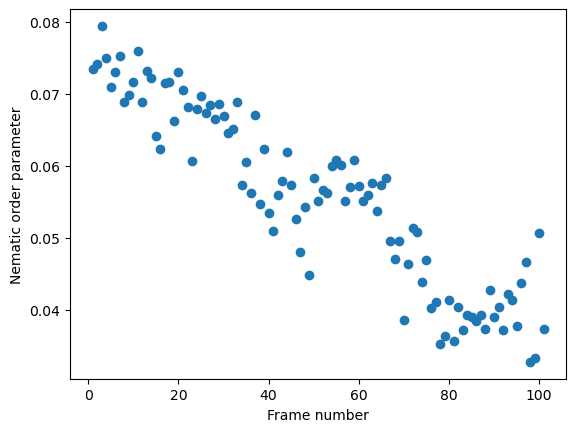

In [8]:
plt.scatter(frames, orders)
plt.xlabel("Frame number")
plt.ylabel("Nematic order parameter")